In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
csv_path = Path("downloads/Mobile_prices.csv")
df = pd.read_csv(csv_path, low_memory=False)

In [3]:
df.head()

,brand,model,price_usd,ram_gb,storage_gb,camera_mp,battery_mah,display_size_inch,charging_watt,5g_support,os,processor,rating,release_month,year
0,Oppo,A98 111,855,16,128,108,6000,6.6,33,Yes,Android,Helio G99,3.8,February,2025
1,Realme,11 Pro+ 843,618,6,128,64,4500,6.9,100,Yes,Android,Tensor G4,4.4,August,2025
2,Xiaomi,Redmi Note 14 Pro 461,258,16,64,64,4000,6.8,44,Yes,Android,A18 Pro,4.1,March,2025
3,Vivo,V29e 744,837,6,512,48,4500,6.0,65,Yes,Android,Exynos 2400,4.1,August,2025
4,Apple,iPhone 16 Pro Max 927,335,12,128,200,5000,6.9,100,Yes,iOS,Dimensity 9300,3.5,February,2025


In [4]:
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['release_month'] = df['release_month'].map(month_map)

In [5]:
df['month_sin'] = np.sin(2 * np.pi * df['release_month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['release_month'] / 12)
df = df.drop(columns=['release_month'])
categories = ['brand','model','5g_support','os','processor']
numerical = ['ram_gb','storage_gb','camera_mp','battery_mah','display_size_inch','charging_watt','rating','year']
df[numerical] = np.log1p(df[numerical])

In [6]:
X = df.drop(columns=['price_usd'])
y = df['price_usd']
y = np.log1p(df['price_usd'])

In [7]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categories),
    ('num', StandardScaler(), numerical)
])

model = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components = 10)),
    ('reg', LinearRegression())
])
        

In [8]:
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Average R²:", scores.mean())

Average R²: -0.017758822353732873


In [9]:
model_no_pca = Pipeline([
    ('preprocess', preprocessor),
    ('reg', LinearRegression())
])

scores_no_pca = cross_val_score(model_no_pca, X, y, cv=5, scoring='r2')
print("Average R² without PCA:", scores_no_pca.mean())

Average R² without PCA: -1.0961165962225774


In [10]:
model_rf = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components = 15)),
    ('reg', RandomForestRegressor(n_estimators=200, random_state=42))
])

scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring='r2')
print("Average R² (Random Forest):", scores_rf.mean())

Average R² (Random Forest): -0.10197972704939029


In [11]:
df[numerical].info()
df[numerical].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ram_gb             1000 non-null   float64
 1   storage_gb         1000 non-null   float64
 2   camera_mp          1000 non-null   float64
 3   battery_mah        1000 non-null   float64
 4   display_size_inch  1000 non-null   float64
 5   charging_watt      1000 non-null   float64
 6   rating             1000 non-null   float64
 7   year               1000 non-null   float64
dtypes: float64(8)
memory usage: 62.6 KB


ram_gb               0
storage_gb           0
camera_mp            0
battery_mah          0
display_size_inch    0
charging_watt        0
rating               0
year                 0
dtype: int64

In [12]:
df['brand'].value_counts(normalize=True)

brand
Vivo       0.122
OnePlus    0.116
Google     0.116
Xiaomi     0.114
Oppo       0.110
Apple      0.107
Realme     0.105
Infinix    0.105
Samsung    0.105
Name: proportion, dtype: float64

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

model_gb = Pipeline([
    ('preprocess', preprocessor),
    #('pca', PCA(n_components = 15)),
    ('reg', GradientBoostingRegressor(random_state=42))
])

scores_gb = cross_val_score(model_gb, X, y, cv=5, scoring='r2')
print("Average R² (Gradient Boosting):", scores_gb.mean())

Average R² (Gradient Boosting): -0.013771568967837178


In [14]:
df[numerical + ['price_usd']].corr()['price_usd'].sort_values(ascending=False)

price_usd            1.000000
charging_watt        0.013239
camera_mp            0.008981
storage_gb           0.008312
rating              -0.003692
battery_mah         -0.009040
display_size_inch   -0.022409
ram_gb              -0.028966
year                      NaN
Name: price_usd, dtype: float64

In [17]:
df.groupby('model')['price_usd'].agg(['count', 'nunique', 'min', 'max'])

,count,nunique,min,max
model,,,,
11 Pro+ 103,1,1,1351,1351
11 Pro+ 210,1,1,910,910
11 Pro+ 320,1,1,317,317
11 Pro+ 376,1,1,112,112
11 Pro+ 590,1,1,809,809
...,...,...,...,...
iPhone 16 Pro Max 927,1,1,335,335
iPhone 16 Pro Max 945,1,1,715,715
iPhone 16 Pro Max 954,1,1,1083,1083


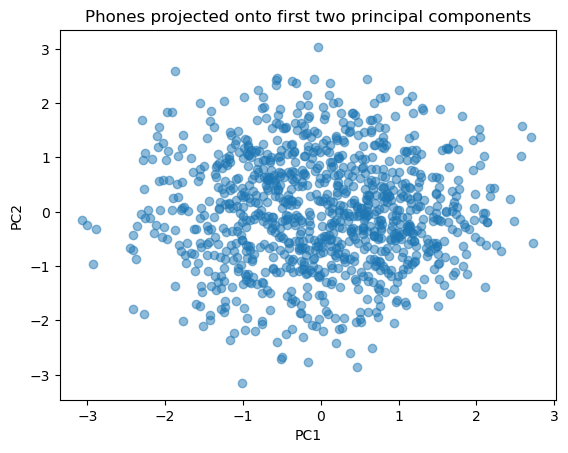

In [18]:
X_prep = preprocessor.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prep)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Phones projected onto first two principal components')
plt.show()

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_prep)
df['cluster'] = clusters

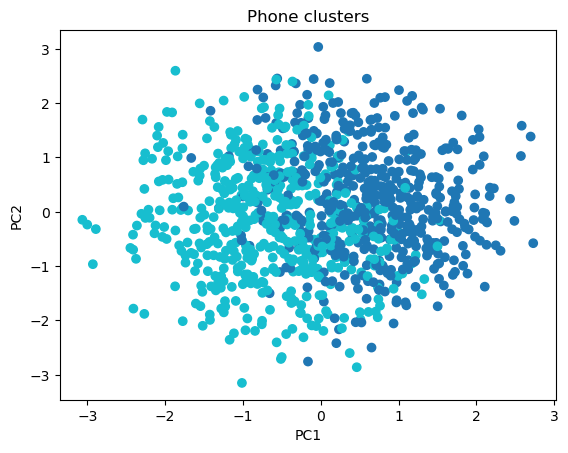

In [24]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Phone clusters')
plt.show()

In [21]:
df.groupby('cluster')[['ram_gb','storage_gb','battery_mah','rating']].mean()

,ram_gb,storage_gb,battery_mah,rating
cluster,,,,
0,2.664255,6.065849,8.520911,1.681194
1,1.910829,5.442088,8.501028,1.638147
2,1.909047,5.794492,8.491317,1.688632
3,2.486538,4.920396,8.528070,1.589836


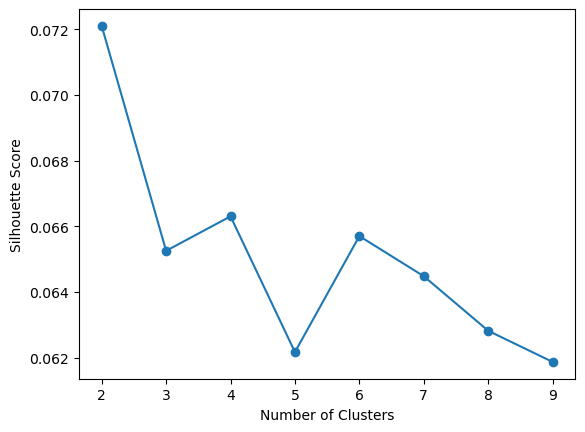

In [22]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_prep)
    scores.append(silhouette_score(X_prep, clusters))

plt.plot(range(2, 10), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [25]:
df.groupby('cluster')[['ram_gb','storage_gb','battery_mah','rating']].mean()

,ram_gb,storage_gb,battery_mah,rating
cluster,,,,
0,2.162130,5.743793,8.508662,1.718610
1,2.292086,5.382690,8.510382,1.581736


<Axes: xlabel='PC1', ylabel='price_usd'>

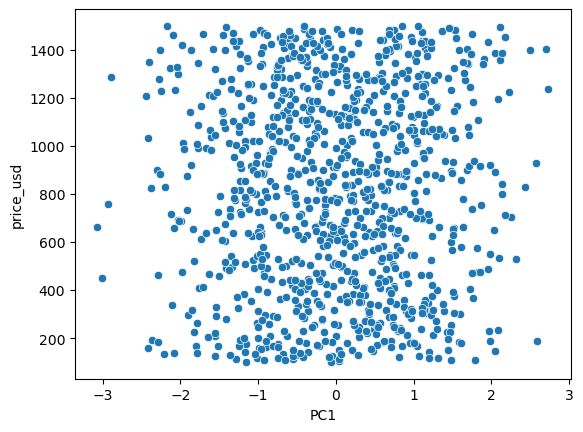

In [26]:
df['PC1'] = X_pca[:, 0]
sns.scatterplot(x='PC1', y='price_usd', data=df)

In [27]:
pd.DataFrame(pca.components_[0], index=preprocessor.get_feature_names_out()).sort_values(0, ascending=False).head(10)

,0
num__storage_gb,0.535875
num__charging_watt,0.491926
num__rating,0.475082
num__display_size_inch,0.419609
num__camera_mp,0.159586
cat__brand_Oppo,0.021562
cat__processor_Dimensity 9300,0.012115
cat__brand_Apple,0.011037
cat__os_iOS,0.011037
cat__5g_support_No,0.010529


In [28]:
df[['PC1','price_usd']].corr(method='spearman')

,PC1,price_usd
PC1,1.000000,0.003569
price_usd,0.003569,1.000000


In [29]:
df.groupby('brand')['PC1'].mean().sort_values()

brand
Samsung   -0.161137
Google    -0.152142
Infinix   -0.098396
Xiaomi    -0.009742
OnePlus    0.001829
Vivo       0.024226
Realme     0.064087
Apple      0.114271
Oppo       0.217148
Name: PC1, dtype: float64